In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CONFIGURATION ET PARAMÈTRES FIXES

GAMMA =1
Q = 2.0
N_SAMPLES = 500  # Nombre de points pour la simu
N_MC = 50  # Nombre de répétitions Monte-Carlo pour lisser les courbes
D = 50 # Dimension de X

# Vrai vecteur beta (direction cible)
TRUE_BETA = np.zeros(D)
TRUE_BETA[:5] = 1.0
TRUE_BETA = TRUE_BETA / np.linalg.norm(TRUE_BETA)

def generate_data(n, kappa, gamma, q):
    """
    Génère des données synthétiques selon le modèle Inverse Single-Index
    X = Y^kappa * beta + noise
    """
    # Génération de Y (Loi de Pareto / Fréchet avec index gamma)
    # U ~ Uniform(0,1) -> Y = U^(-gamma)
    U = np.random.uniform(0, 1, n)
    Y = U**(-gamma)
    
    # Génération du Bruit (Noise) avec integrabilité q
    # On prend un bruit Student-t ou similaire pour respecter q
    Noise = np.random.standard_t(df=q+0.1, size=(n, D)) 
    
    # Construction de X : Signal + Bruit
    # Le signal est modulé par g(Y) ~ Y^kappa
    signal_strength = Y[:, np.newaxis] ** kappa
    X = signal_strength * TRUE_BETA + Noise
    
    return X, Y

def fepls_estimator(X, Y, k, tau):
    """
    Calcule l'estimateur FEPLS beta_hat pour un k et tau donné.
    """
    n = len(Y)
    
    # Seuil
    y_sorted = np.sort(Y)
    threshold = y_sorted[n-k]
    
    
    indices = np.where(Y >= threshold)[0]
    
    
    weights = Y[indices] ** tau
    
  
    X_extreme = X[indices]
  
    weighted_sum = np.sum(X_extreme * weights[:, np.newaxis], axis=0)
    
  
    norm = np.linalg.norm(weighted_sum)
    if norm == 0:
        return np.zeros_like(weighted_sum)
    return weighted_sum / norm

def admissible_kappa_tau(gamma, q, kappa, tau):
    """
    On vérifie les inégalités FEPLS :
      1) q * kappa * gamma > 1
      2) 0 < 2 * (kappa + tau) * gamma < 1
    """
    return (q * kappa * gamma > 1.0) and (0.0 < 2.0 * (kappa + tau) * gamma < 1.0)

def taus_for_kappa(kappa, gamma, n_tau=5, eps=1e-2):
    """
    On construit une petite grille de valeurs de tau proches des bornes d’inégalité :
      -kappa < tau < 1/(2*gamma) - kappa
    et on reste à l’intérieur de l’intervalle avec marge > epsilon.
    """
    tau_lower = -kappa + eps
    tau_upper = (1.0 / (2.0 * gamma)) - kappa - eps
    if tau_lower >= tau_upper:
        return []
    return np.linspace(tau_lower, tau_upper, n_tau)


# --- BOUCLE DE SIMULATION, AVEC KAPPA, TAU PROCHE DES BORNES

# On choisit des kappas proches de la borne inférieure kappa > 1 / (Q * GAMMA)
eps_kappa = 1e-2  # on reste légèrement à l’intérieur de q*kappa*gamma > 1
kappa_min = 1.0 / (Q * GAMMA) + eps_kappa
kappa_max = 2.5
N_KAPPA  = 20

kappas_to_test = np.linspace(kappa_min, kappa_max, N_KAPPA)
print("Grille de kappa :", np.round(kappas_to_test, 3))
# plage de k (nombre d’extrêmes testés)
k_values = range(10, 500, 10)

# stockage des résultats : results[kappa][tau] = {...}
results = {}

print("Lancement des simulations (avec kappas et taus proches des bornes d’inégalités)...")
print(f"gamma={GAMMA}, q={Q}")
print(f"grille des kappas : {kappas_to_test}")

for kappa in kappas_to_test:

    tau_values = taus_for_kappa(kappa, GAMMA, n_tau=5, eps=1e-2)
    
    # on conserve seulement les (kappa, tau) admissibles
    tau_values = [tau for tau in tau_values if admissible_kappa_tau(GAMMA, Q, kappa, tau)]

    if len(tau_values) == 0:
        print(f"kappa={kappa:.3f} : aucune valeur admissible de tau, on saute.")
        continue

    print(f"\nSimulation pour kappa = {kappa:.3f}, taus = {np.round(tau_values, 3)}")
    results[kappa] = {}

    for tau_fixe in tau_values:
        print(f"  tau = {tau_fixe:.3f}")
        bias_list = []
        variance_list = []
        mse_list = []

        for k in k_values:
            betas = []

            # Monte Carlo pour estimer biais et variance
            for _ in range(N_MC):
                X, Y = generate_data(N_SAMPLES, kappa, GAMMA, Q)
                beta_hat = fepls_estimator(X, Y, k, tau_fixe)
                betas.append(beta_hat)

            betas = np.array(betas)

            
            mean_beta = np.mean(betas, axis=0)
            bias_sq = np.sum((mean_beta - TRUE_BETA) ** 2)
            
            variance = np.mean(np.sum((betas - mean_beta) ** 2, axis=1))

        
            mse = bias_sq + variance

            bias_list.append(bias_sq)
            variance_list.append(variance)
            mse_list.append(mse)

        results[kappa][tau_fixe] = {
            "k": list(k_values),
            "bias": bias_list,
            "variance": variance_list,
            "mse": mse_list,
        }

# --- GRAPHIQUES SIMPLES (ON FIXE UN TAU PAR KAPPA, POUR ILLUSTRATION)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax_mse, ax_var, ax_bias, ax_kopt = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

fig.suptitle(f'Biais-Variance FEPLS (gamma={GAMMA}, q={Q})', fontsize=16)

# Pour chaque kappa, on choisit le tau qui minimise la MSE moyenne
for kappa in sorted(results.keys()):
    tau_candidates = list(results[kappa].keys())
    avg_mse_per_tau = []
    for tau in tau_candidates:
        avg_mse = np.mean(results[kappa][tau]["mse"])
        avg_mse_per_tau.append(avg_mse)
    best_tau = tau_candidates[int(np.argmin(avg_mse_per_tau))]

    res = results[kappa][best_tau]
    label = rf'$\kappa={kappa:.2f}, \tau={best_tau:.2f}$'


    ax_mse.plot(res["k"], res["mse"], label=label)


    ax_var.plot(res["k"], res["variance"], linestyle="--", label=label)


    ax_bias.plot(res["k"], res["bias"], linestyle=":", label=label)


    idx_min = int(np.argmin(res["mse"]))
    k_opt = res["k"][idx_min]
    ax_kopt.scatter(kappa, k_opt, label=label)


ax_mse.set_title("Erreur quadratique moyenne (MSE)")
ax_mse.set_xlabel("k (nombre d’extrêmes)")
ax_mse.set_ylabel("MSE")
ax_mse.set_yscale("log")
ax_mse.grid(True, which="both", ls="-", alpha=0.5)
ax_mse.legend()

ax_var.set_title("Variance (bruit d’estimation)")
ax_var.set_xlabel("k")
ax_var.set_yscale("log")
ax_var.grid(True)
ax_var.legend()

ax_bias.set_title("Biais au carré (erreur d’approximation)")
ax_bias.set_xlabel("k")
ax_bias.set_yscale("log")
ax_bias.grid(True)
ax_bias.legend()

ax_kopt.set_title("k optimal en fonction de $\kappa$ (meilleur tau par $\kappa$)")
ax_kopt.set_xlabel("$\kappa$")
ax_kopt.set_ylabel("k optimal")
ax_kopt.grid(True)
ax_kopt.legend()

plt.tight_layout()
plt.show()

<>:211: SyntaxWarning: invalid escape sequence '\k'
<>:212: SyntaxWarning: invalid escape sequence '\k'
<>:211: SyntaxWarning: invalid escape sequence '\k'
<>:212: SyntaxWarning: invalid escape sequence '\k'
C:\Users\simon\AppData\Local\Temp\ipykernel_27944\1444832353.py:211: SyntaxWarning: invalid escape sequence '\k'
  ax_kopt.set_title("k optimal en fonction de $\kappa$ (meilleur tau par $\kappa$)")
C:\Users\simon\AppData\Local\Temp\ipykernel_27944\1444832353.py:212: SyntaxWarning: invalid escape sequence '\k'
  ax_kopt.set_xlabel("$\kappa$")


Grille de kappa : [0.51  0.615 0.719 0.824 0.929 1.034 1.138 1.243 1.348 1.453 1.557 1.662
 1.767 1.872 1.976 2.081 2.186 2.291 2.395 2.5  ]
Lancement des simulations (avec kappas et taus proches des bornes d’inégalités)...
gamma=1, q=2.0
grille des kappas : [0.51       0.61473684 0.71947368 0.82421053 0.92894737 1.03368421
 1.13842105 1.24315789 1.34789474 1.45263158 1.55736842 1.66210526
 1.76684211 1.87157895 1.97631579 2.08105263 2.18578947 2.29052632
 2.39526316 2.5       ]

Simulation pour kappa = 0.510, taus = [-0.5  -0.38 -0.26 -0.14 -0.02]
  tau = -0.500
  tau = -0.380
  tau = -0.260
  tau = -0.140
  tau = -0.020

Simulation pour kappa = 0.615, taus = [-0.605 -0.485 -0.365 -0.245 -0.125]
  tau = -0.605
  tau = -0.485
  tau = -0.365
  tau = -0.245
  tau = -0.125

Simulation pour kappa = 0.719, taus = [-0.709 -0.589 -0.469 -0.349 -0.229]
  tau = -0.709
  tau = -0.589
  tau = -0.469


kappa grid: [0.51  0.523 0.535 0.548 0.561 0.573 0.586 0.598 0.611 0.624 0.636 0.649
 0.662 0.674 0.687 0.699 0.712 0.725 0.737 0.75 ]
Lancement des simulations (kappas et 3 taus: bord gauche / milieu / bord droit)...
gamma=1.0, q=2.0
grille de kappa: [0.51       0.52263158 0.53526316 0.54789474 0.56052632 0.57315789
 0.58578947 0.59842105 0.61105263 0.62368421 0.63631579 0.64894737
 0.66157895 0.67421053 0.68684211 0.69947368 0.71210526 0.72473684
 0.73736842 0.75      ]

Simulation pour kappa = 0.510
  taus utilisés (label: valeur) : {'left': np.float64(-0.5), 'mid': np.float64(-0.26), 'right': np.float64(-0.02)}
  -> tau_label = left, tau = -0.500
  -> tau_label = mid, tau = -0.260
  -> tau_label = right, tau = -0.020

Simulation pour kappa = 0.523
  taus utilisés (label: valeur) : {'left': np.float64(-0.513), 'mid': np.float64(-0.273), 'right': np.float64(-0.033)}
  -> tau_label = left, tau = -0.513
  -> tau_label = mid, tau = -0.273
  -> tau_label = right, tau = -0.033

Simulation

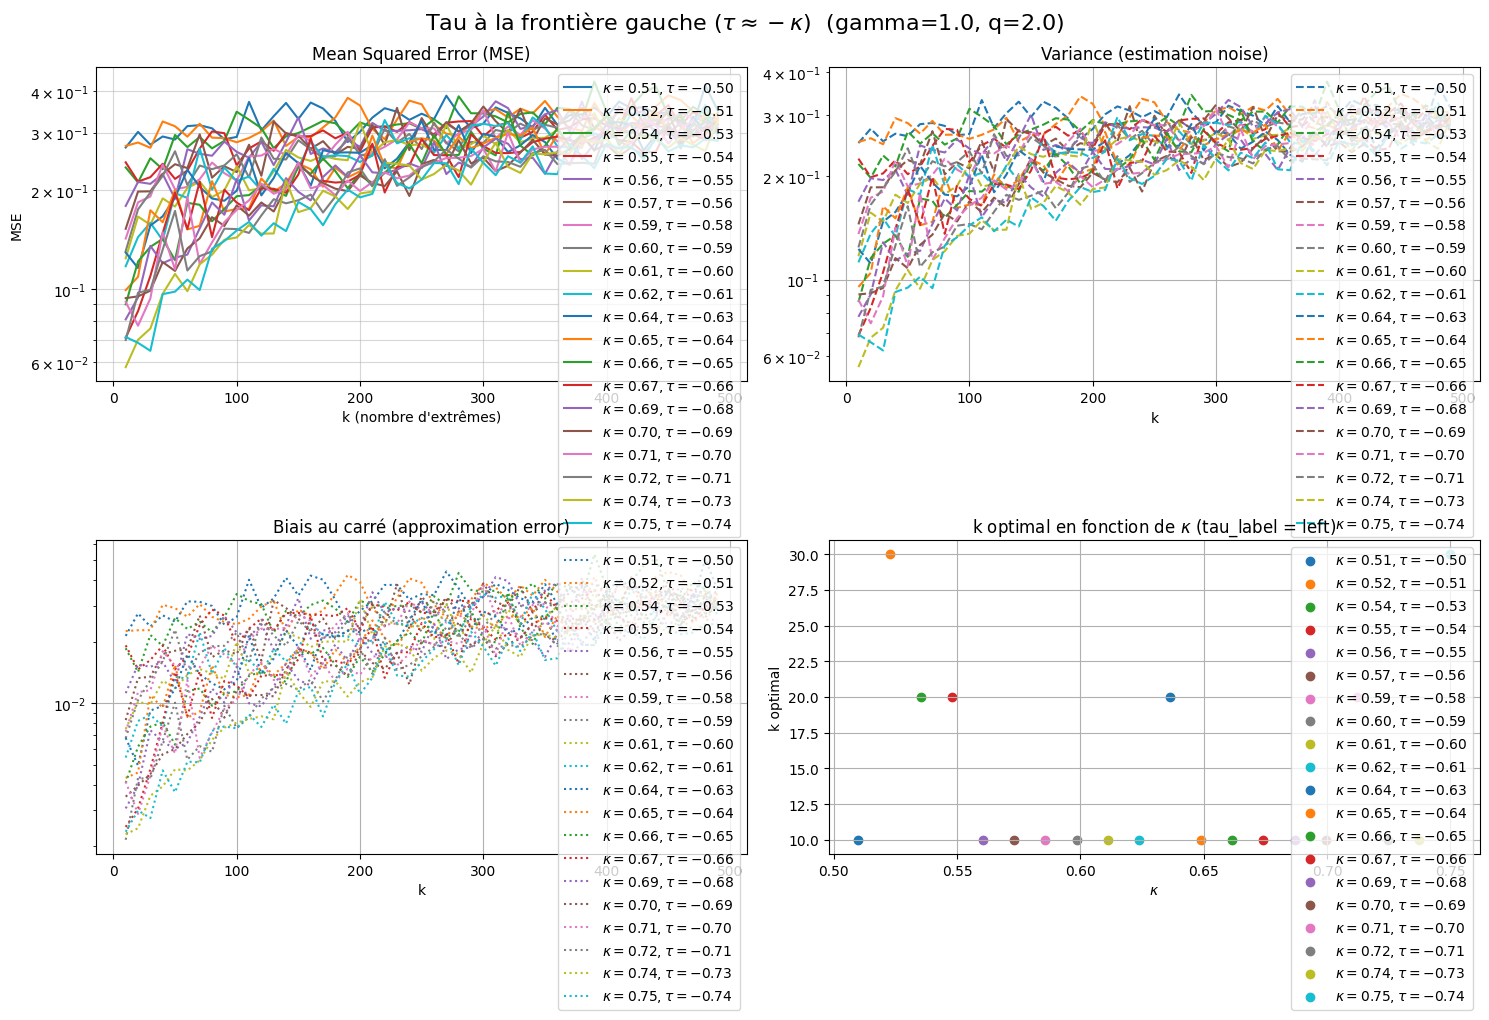

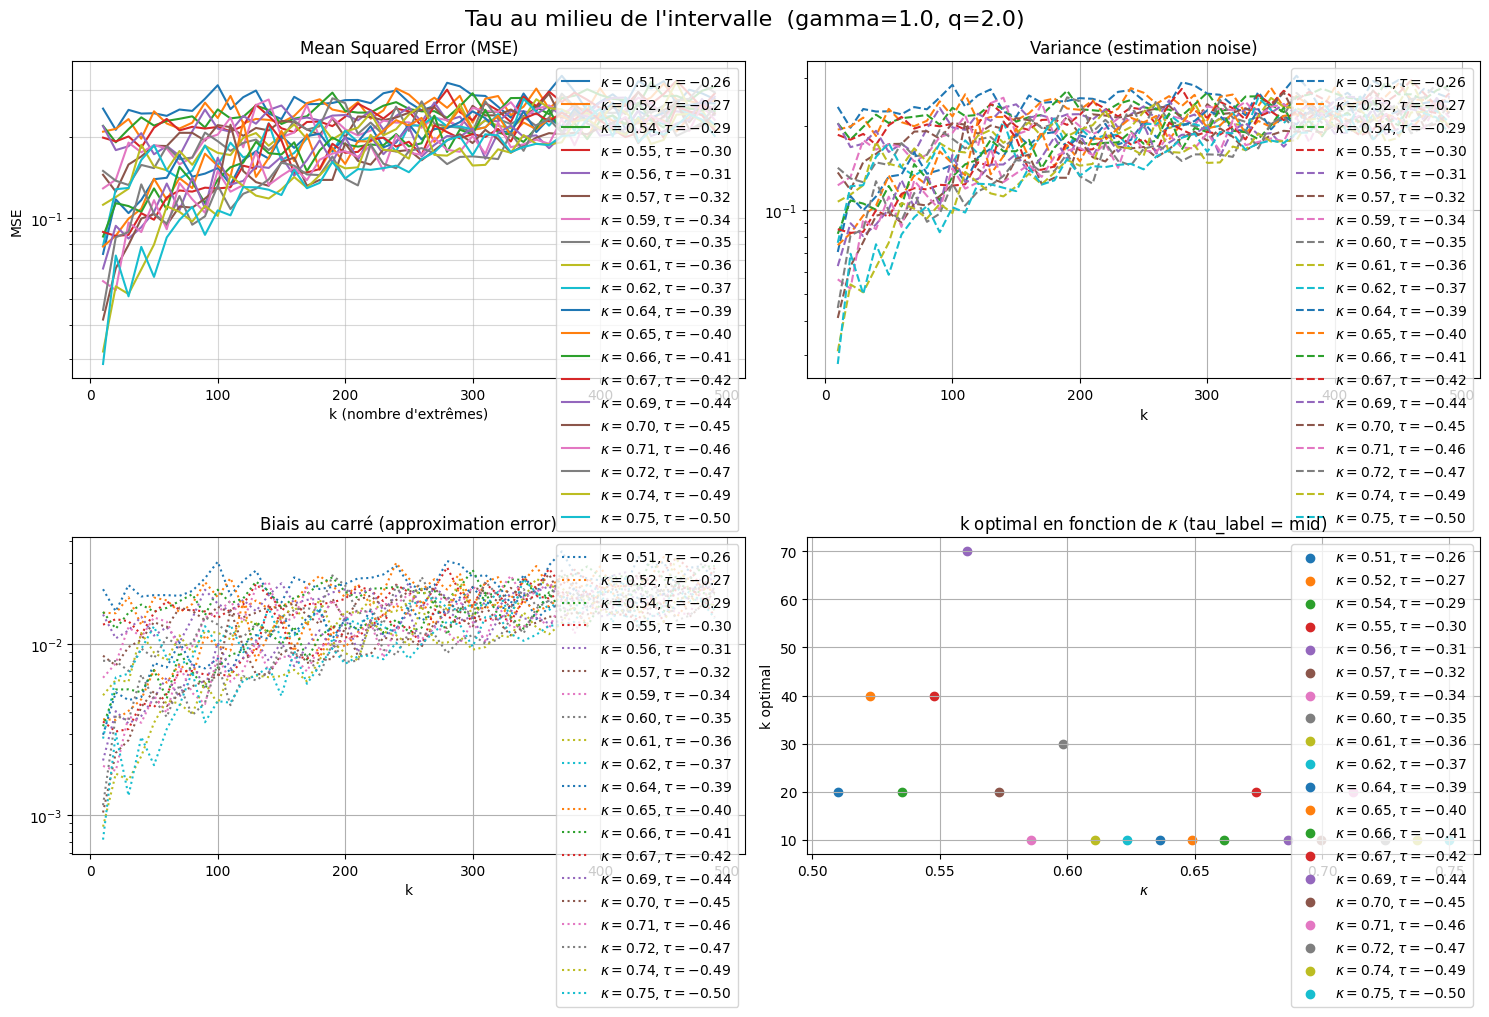

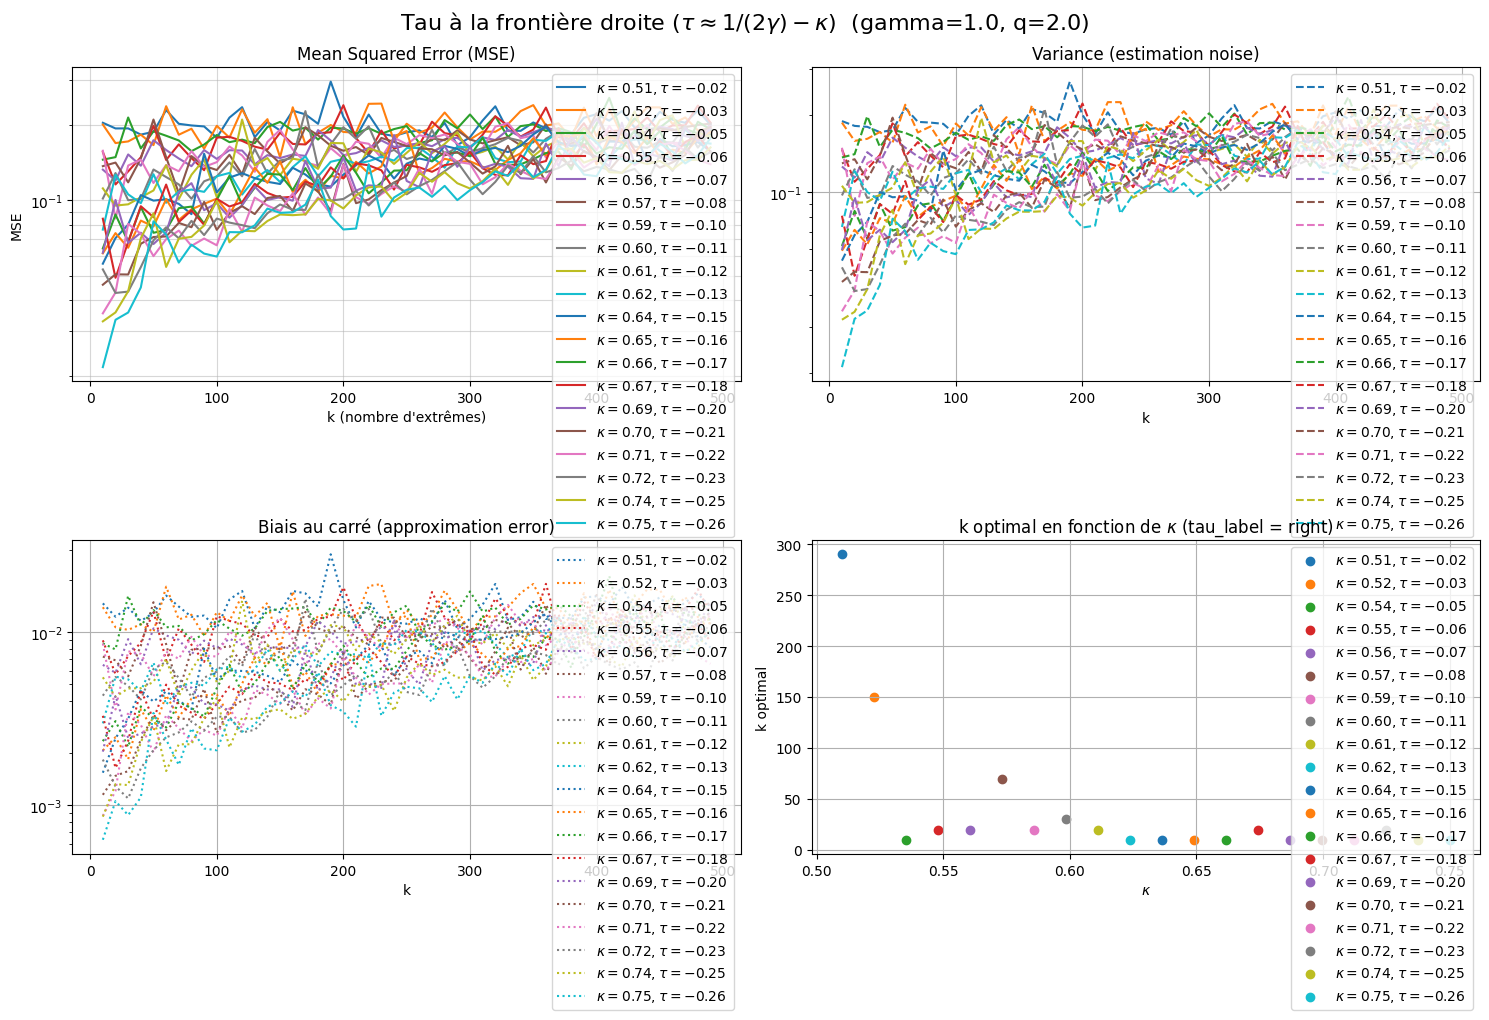

In [ ]:
# --- BOUCLE DE SIMULATION AVEC KAPPA, ET 3 TAU (GAUCHE/MILIEU/DROITE)

# we choose kappas near the lower bound kappa > 1 / (Q * GAMMA)
eps_kappa = 1e-2  # we stay slightly inside q*kappa*gamma > 1
kappa_min = 1.0 / (Q * GAMMA) + eps_kappa
kappa_max = 0.75                     # you can adjust the upper bound if needed
N_KAPPA  = 20                        # we choose about twenty kappa values

kappas_to_test = np.linspace(kappa_min, kappa_max, N_KAPPA)
print("kappa grid:", np.round(kappas_to_test, 3))

# plage de k (nombre d'extrêmes) à tester
k_values = range(10, 500, 10)

# stockage des résultats: results[kappa][tau_label] = {...}
results = {}

print("Lancement des simulations (kappas et 3 taus: bord gauche / milieu / bord droit)...")
print(f"gamma={GAMMA}, q={Q}")
print(f"grille de kappa: {kappas_to_test}")

for kappa in kappas_to_test:
    tau_dict = taus_for_kappa(kappa, GAMMA, eps=1e-2)
    # we keep only admissible (kappa, tau)
    tau_dict = {
        label: tau
        for label, tau in tau_dict.items()
        if admissible_kappa_tau(GAMMA, Q, kappa, tau)
    }

    if len(tau_dict) == 0:
        print(f"kappa={kappa:.3f}: aucune valeur de tau admissible (même aux frontières), on saute.")
        continue

    print(f"\nSimulation pour kappa = {kappa:.3f}")
    print("  taus utilisés (label: valeur) :", {lab: round(val, 3) for lab, val in tau_dict.items()})
    results[kappa] = {}

    for tau_label, tau_fixe in tau_dict.items():
        print(f"  -> tau_label = {tau_label}, tau = {tau_fixe:.3f}")
        bias_list = []
        variance_list = []
        mse_list = []

        for k in k_values:
            betas = []

            # Monte Carlo pour estimer biais et variance
            for _ in range(N_MC):
                X, Y = generate_data(N_SAMPLES, kappa, GAMMA, Q)
                beta_hat = fepls_estimator(X, Y, k, tau_fixe)
                betas.append(beta_hat)

            betas = np.array(betas)

            # biais^2
            mean_beta = np.mean(betas, axis=0)
            bias_sq = np.sum((mean_beta - TRUE_BETA) ** 2)

            # variance
            variance = np.mean(np.sum((betas - mean_beta) ** 2, axis=1))

            # MSE = biais^2 + variance
            mse = bias_sq + variance

            bias_list.append(bias_sq)
            variance_list.append(variance)
            mse_list.append(mse)

        results[kappa][tau_label] = {
            "tau": tau_fixe,
            "k": list(k_values),
            "bias": bias_list,
            "variance": variance_list,
            "mse": mse_list,
        }

# --- PLOTS : 3 GRANDES FIGURES (TAU GAUCHE / TAU MILIEU / TAU DROIT)

tau_labels_order = ["left", "mid", "right"]
tau_titles = {
    "left": "Tau à la frontière gauche ($\\tau \\approx -\\kappa$)",
    "mid": "Tau au milieu de l'intervalle",
    "right": "Tau à la frontière droite ($\\tau \\approx 1/(2\\gamma)-\\kappa$)",
}

for tau_label in tau_labels_order:
    # we check if at least one kappa has this tau_label
    has_data = any(
        (kappa in results) and (tau_label in results[kappa])
        for kappa in results.keys()
    )
    if not has_data:
        print(f"\nAucune donnée pour tau_label = '{tau_label}', on ne trace pas cette figure.")
        continue

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    ax_mse, ax_var, ax_bias, ax_kopt = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

    fig.suptitle(
        f"{tau_titles[tau_label]}  (gamma={GAMMA}, q={Q})",
        fontsize=16
    )

    for kappa in sorted(results.keys()):
        if tau_label not in results[kappa]:
            continue
        res = results[kappa][tau_label]
        tau_val = res["tau"]
        label = rf'$\kappa={kappa:.2f}, \tau={tau_val:.2f}$'

        # MSE vs k
        ax_mse.plot(res["k"], res["mse"], label=label)

        # variance vs k
        ax_var.plot(res["k"], res["variance"], linestyle="--", label=label)

        # biais^2 vs k
        ax_bias.plot(res["k"], res["bias"], linestyle=":", label=label)

        # k_opt pour ce couple (kappa, tau_label)
        idx_min = int(np.argmin(res["mse"]))
        k_opt = res["k"][idx_min]
        ax_kopt.scatter(kappa, k_opt, label=label)

    # mise en forme des axes
    ax_mse.set_title("Mean Squared Error (MSE)")
    ax_mse.set_xlabel("k (nombre d'extrêmes)")
    ax_mse.set_ylabel("MSE")
    ax_mse.set_yscale("log")
    ax_mse.grid(True, which="both", ls="-", alpha=0.5)
    ax_mse.legend()

    ax_var.set_title("Variance (estimation noise)")
    ax_var.set_xlabel("k")
    ax_var.set_yscale("log")
    ax_var.grid(True)
    ax_var.legend()

    ax_bias.set_title("Biais au carré (approximation error)")
    ax_bias.set_xlabel("k")
    ax_bias.set_yscale("log")
    ax_bias.grid(True)
    ax_bias.legend()

    ax_kopt.set_title("k optimal en fonction de $\\kappa$ "
                      f"(tau_label = {tau_label})")
    ax_kopt.set_xlabel("$\\kappa$")
    ax_kopt.set_ylabel("k optimal")
    ax_kopt.grid(True)
    ax_kopt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# --- VARIATION DE n POUR VÉRIFIER LE TAUX DE CONVERGENCE EN n

# on fixe un couple (kappa0, tau0) admissible
kappa0 = float(kappas_to_test[len(kappas_to_test) // 2])  # on prend un kappa au milieu de la grille
tau0_dict = taus_for_kappa(kappa0, GAMMA, eps=1e-2)
# on choisit par exemple le tau "mid" si admissible, sinon le premier dispo
if "mid" in tau0_dict and admissible_kappa_tau(GAMMA, Q, kappa0, tau0_dict["mid"]):
    tau0 = tau0_dict["mid"]
else:
    # we take any admissible tau for this kappa
    tau0 = None
    for t in tau0_dict.values():
        if admissible_kappa_tau(GAMMA, Q, kappa0, t):
            tau0 = t
            break
if tau0 is None:
    print("Aucun tau admissible trouvé pour kappa0, on saute la partie n-variation.")
else:
    print(f"\n[PARTIE n] On fixe kappa0={kappa0:.3f}, tau0={tau0:.3f} pour étudier le taux de convergence en n.")

    # on choisit une suite de tailles d'échantillon n
    n_values = np.array([200, 300, 400, 500, 700, 1000, 1500, 2000, 3000])

    # on choisit un rho de seconde ordre (théorique), par exemple rho = -1/2
    rho = -0.5
    # exponent théorique pour delta_{n,k}: n^{(1/q - gamma*kappa)/(1 - 2*rho)}
    exponent_theorique = (1.0 / Q - GAMMA * kappa0) / (1.0 - 2.0 * rho)
    print(f"[PARTIE n] Exposant théorique attendu pour delta_n,k ~ n^{exponent_theorique:.4f}")

    # pour satisfaire sqrt(k) A(n/k) = O(1) avec A(t) ~ t^rho, on prend k_n ~ c * n^{-2rho/(1-2rho)}
    alpha_k = -2.0 * rho / (1.0 - 2.0 * rho)  # ici rho=-1/2 => alpha_k=1/2
    c_k = 5.0  # constante arbitraire
    print(f"[PARTIE n] On choisit k_n ~ c * n^{alpha_k:.3f} avec c={c_k}")

    mean_error_list = []
    std_error_list = []
    k_used_list = []

    for n in n_values:
        k_n = int(min(max(5, c_k * n**alpha_k), n // 5))  # 5 <= k_n <= n/5
        k_used_list.append(k_n)
        print(f"  n={n}, k_n={k_n}")

        errors = []

        for _ in range(N_MC):
            X, Y = generate_data(n, kappa0, GAMMA, Q)
            beta_hat = fepls_estimator(X, Y, k_n, tau0)
            err = np.linalg.norm(beta_hat - TRUE_BETA)
            errors.append(err)

        errors = np.array(errors)
        mean_error_list.append(errors.mean())
        std_error_list.append(errors.std())

    mean_error_list = np.array(mean_error_list)
    std_error_list = np.array(std_error_list)
    k_used_list = np.array(k_used_list)

    # plot en log-log : erreur vs n
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].set_title(r"Convergence de $\|\hat\beta - \beta\|$ en fonction de $n$")
    ax[0].set_xlabel("n")
    ax[0].set_ylabel(r"$\mathbb{E}\|\hat\beta - \beta\|$")
    ax[0].loglog(n_values, mean_error_list, marker="o", label="erreur moyenne")
    ax[0].grid(True, which="both", ls="-", alpha=0.5)

    # courbe de référence théorique: C * n^{exponent_theorique}, ajustée au premier point
    if len(n_values) > 0:
        C_ref = mean_error_list[0] / (n_values[0] ** exponent_theorique)
        ref_curve = C_ref * (n_values ** exponent_theorique)
        ax[0].loglog(n_values, ref_curve, linestyle="--", label=rf"ref $\propto n^{{{exponent_theorique:.2f}}}$")
        ax[0].legend()

    # plot de k_n en fonction de n pour voir la séquence intermédiaire
    ax[1].set_title(r"Séquence intermédiaire $k_n$ en fonction de $n$")
    ax[1].set_xlabel("n")
    ax[1].set_ylabel(r"$k_n$")
    ax[1].loglog(n_values, k_used_list, marker="s", label=r"$k_n$")
    ax[1].grid(True, which="both", ls="-", alpha=0.5)
    ax[1].legend()

    plt.tight_layout()
    plt.show()